# Setup

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [81]:
os.chdir(root+ "/functions")
import modelling

In [82]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 02 Overfit

In this notebook I am loading the train data and training it for many epochs. I want to see whether I can overfit it to perfect (1.0) F1 Scores. That would mean that the model can perform the basic task. As a model I am using a mobilenet because it is small and adjusted the last layers for my purposes.

In [83]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 625 files belonging to 3 classes.
Using 500 files for training.


In [84]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 625 files belonging to 3 classes.
Using 125 files for validation.


In [85]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_test,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=False,
)

Found 152 files belonging to 3 classes.


In [86]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
mobileNet = MobileNet(weights='imagenet', include_top=False)
model = modelling.recompile_model(mobileNet, 'rmsprop', 'categorical_crossentropy')

In [88]:
epochs=35
history = model.fit(
  train_ds,
  epochs=epochs
  )

Epoch 1/35
16/16 [==============================] - 4s 66ms/step - loss: 3.6240 - accuracy: 0.3900
Epoch 2/35
16/16 [==============================] - 1s 43ms/step - loss: 1.0831 - accuracy: 0.5260
Epoch 3/35
16/16 [==============================] - 1s 39ms/step - loss: 0.9846 - accuracy: 0.5860
Epoch 4/35
16/16 [==============================] - 1s 39ms/step - loss: 0.8654 - accuracy: 0.6080
Epoch 5/35
16/16 [==============================] - 1s 41ms/step - loss: 0.7725 - accuracy: 0.6680
Epoch 6/35
16/16 [==============================] - 1s 42ms/step - loss: 0.7090 - accuracy: 0.6900
Epoch 7/35
16/16 [==============================] - 1s 40ms/step - loss: 0.7147 - accuracy: 0.7100
Epoch 8/35
16/16 [==============================] - 1s 40ms/step - loss: 0.6021 - accuracy: 0.7380
Epoch 9/35
16/16 [==============================] - 1s 39ms/step - loss: 0.6762 - accuracy: 0.7420
Epoch 10/35
16/16 [==============================] - 1s 39ms/step - loss: 0.4789 - accuracy: 0.7960
Epoch 11/

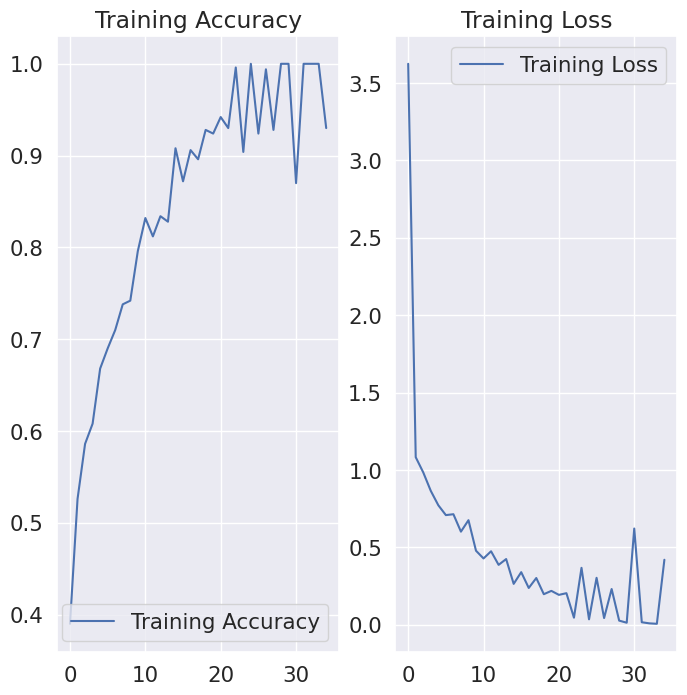

In [89]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [90]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = modelling.extract_labels_categorical(train_ds)

16/16 [==============================] - 1s 36ms/step


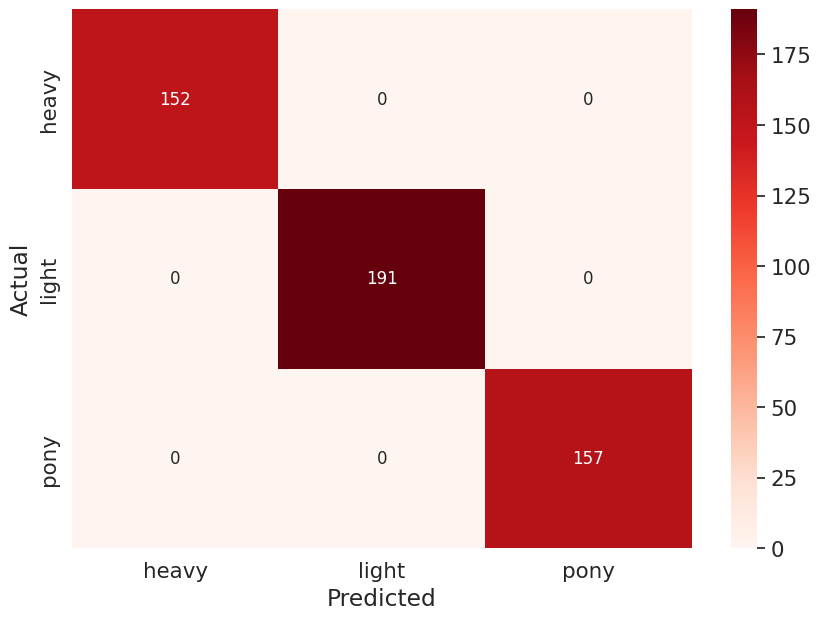

In [91]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
modelling.plot_cm(confusion_matrix_train, class_names)

In [92]:
import pandas as pd
report = pd.DataFrame(columns=['dataset','precision','recall','f1'])

In [93]:
training_report = classification_report(train_true_labels,train_predicted_labels, output_dict=True)
training = {'dataset':'training', 'precision': training_report['weighted avg']['precision'], 'recall': training_report['weighted avg']['recall'], 'f1':training_report['weighted avg']['f1-score']}

In [94]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = modelling.extract_labels_categorical(val_ds)

4/4 [==============================] - 1s 35ms/step


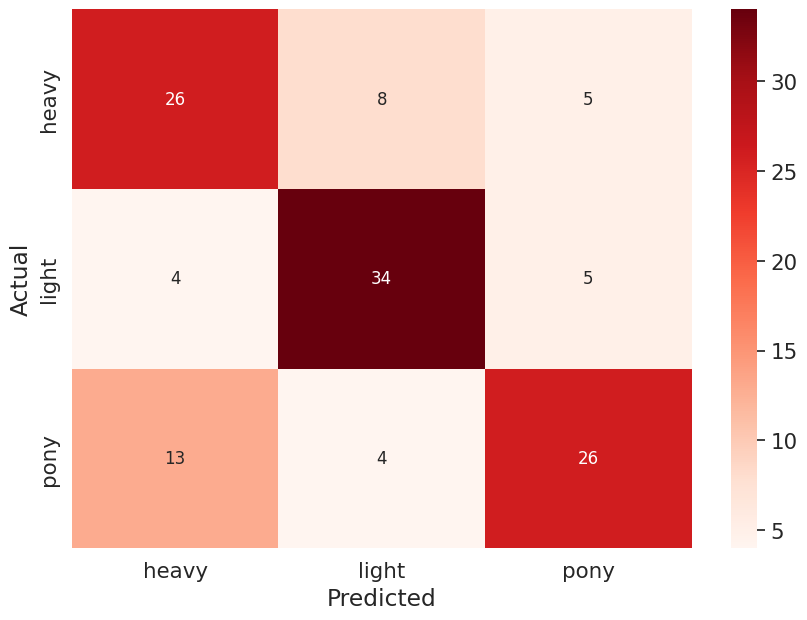

In [95]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
modelling.plot_cm(confusion_matrix_val, class_names)

In [96]:
val_report = classification_report(val_true_labels,val_predicted_labels, output_dict=True)
validation = {'dataset':'validation', 'precision': val_report['weighted avg']['precision'], 'recall': val_report['weighted avg']['recall'], 'f1':val_report['weighted avg']['f1-score']}

In [97]:
testset_predictions = model.predict(test_ds)
test_predicted_labels = [prediction.argmax() for prediction in testset_predictions]
test_true_labels = modelling.extract_labels_categorical(test_ds)

5/5 [==============================] - 1s 123ms/step


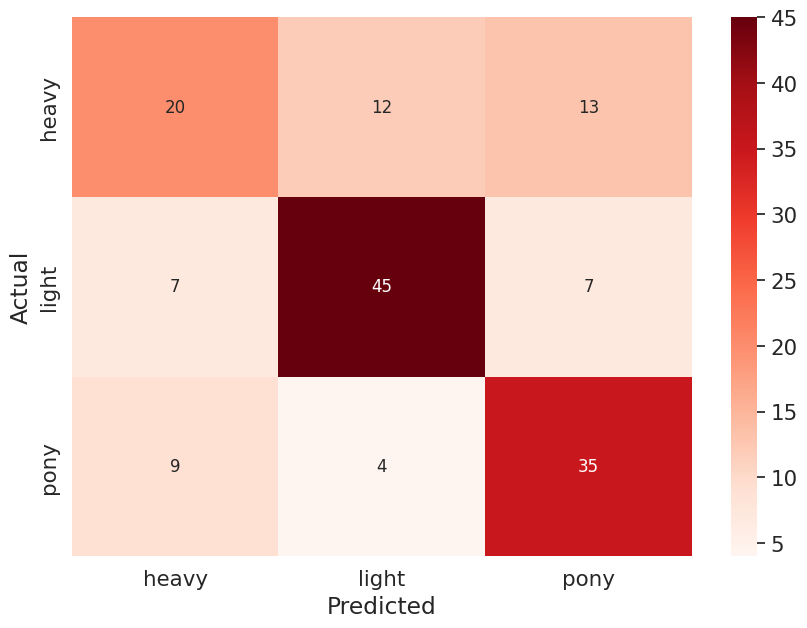

In [98]:
confusion_matrix_test = np.array(tf.math.confusion_matrix(test_true_labels, test_predicted_labels))
confusion_matrix_test = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)
modelling.plot_cm(confusion_matrix_test, class_names)

In [99]:
test_report = classification_report(test_true_labels,test_predicted_labels, output_dict=True)
test = {'dataset':'test', 'precision': test_report['weighted avg']['precision'], 'recall': test_report['weighted avg']['recall'], 'f1':test_report['weighted avg']['f1-score']}

In [100]:
report = report.append(training, ignore_index=True)
report = report.append(validation, ignore_index=True)
report = report.append(test, ignore_index=True)

<ipython-input-100-29a94b9ba1ff>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(training, ignore_index=True)
<ipython-input-100-29a94b9ba1ff>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(validation, ignore_index=True)
<ipython-input-100-29a94b9ba1ff>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report = report.append(test, ignore_index=True)


# Summary

- I trained the model for 35 epochs and it provided me with the perfect F1 scores for the training.
- The validation and test data performs suprisingly good as well when kept in mind that nothing was done to regularize or improve the pipeline

In [101]:
report.head(3)

,dataset,precision,recall,f1
0,training,1.000000,1.000000,1.000000
1,validation,0.691356,0.688000,0.687115
2,test,0.651777,0.657895,0.651931
